# Eindhoven University of Technology, Netherlands.
## Mathematics & Computer Science
## Data Science Master track
## Recommender Systems
Lecturer: Dr. Vlado Menkovski
- Franziska Boenisch
- Adriano Cardace 
- Camilo Montenegro Hernandez

## Sequence Classification

## Task 1.2: Aspect-level Sentiment Classification

Build an attention-based aspect-level sentiment classification model with RNN. Your model shall
include:

- RNN network that learns sentence representation from input sequences.
- Attention network that assigns attention score over a sequence of RNN hidden states based on aspect terms representation.
- Fully connected network that predicts sentiment label, given the representation weighted by the attention score.

Train the model by using data iterator and batch generator. Evaluate the trained model on
the provided test set.

## Model

In [ ]:
import os
import sys
import codecs
import operator
import numpy as np
import re
from time import time
import _pickle as cPickle
import IPython
import keras
import pandas as pd
import tensorflow as tf
import keras.backend as K
# doc_path = './doc_level-sentiment/doc_level'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# !cp './gdrive/My Drive/Colab Notebooks/2lMM10/assignment3/doc_level_sentiment/doc_level'

In [ ]:
aspect_path = 'gdrive/My Drive/aspect_level-sentiment/aspect_level'


### Training

Preprocess data

In [ ]:
num_regex = re.compile('^[+-]?[0-9]+\.?[0-9]*$')

def is_number(token):
    return bool(num_regex.match(token))


def create_vocab(domain, aspect_path, maxlen=0, vocab_size=0):
    
    assert domain in ['res_14', 'lt_14', 'res_15', 'res_16']

    file_list = [os.path.join(aspect_path,'%s_train_sentence.txt'%(domain)),
                 os.path.join(aspect_path,'%s_test_sentence.txt'%(domain))]

    print ('Creating vocab ...')

    total_words, unique_words = 0, 0
    word_freqs = {}

    for f in file_list:
        top = 0
        fin = codecs.open(f, 'r', 'utf-8')
        for line in fin:
            words = line.split()
            if maxlen > 0 and len(words) > maxlen:
                continue
            for w in words:
                if not is_number(w):
                    try:
                        word_freqs[w] += 1
                    except KeyError:
                        unique_words += 1
                        word_freqs[w] = 1
                    total_words += 1

    print ('  %i total words, %i unique words' % (total_words, unique_words))
    sorted_word_freqs = sorted(word_freqs.items(), key=operator.itemgetter(1), reverse=True)

    vocab = {'<pad>':0, '<unk>':1, '<num>':2}
    index = len(vocab)
    for word, _ in sorted_word_freqs:
        vocab[word] = index
        index += 1
        if vocab_size > 0 and index > vocab_size + 2:
            break
    if vocab_size > 0:
        print (' keep the top %i words' % vocab_size)

    
    return vocab

In [ ]:
def read_dataset_aspect(domain, aspect_path, phase, vocab, maxlen):
    
    assert domain in ['res_14', 'lt_14', 'res_15', 'res_16']
    assert phase in ['train', 'test']
    
    print ('Preparing dataset ...')

    data_x, data_y, aspect = [], [], []
    polarity_category = {'positive': 0, 'negative': 1, 'neutral': 2}
    
    if(phase == 'train'):
        file_names = [os.path.join(aspect_path,'%s_%s_sentence.txt'%(domain, phase)),
                   os.path.join(aspect_path,'%s_%s_polarity.txt'%(domain, phase)),
                   os.path.join(aspect_path,'%s_%s_term.txt'%(domain, phase))]
    else:
        file_names = [os.path.join(aspect_path, '%s_%s_sentence.txt'%(domain, phase)),
                   os.path.join(aspect_path, '%s_%s_polarity.txt'%(domain, phase)),
                   os.path.join(aspect_path, '%s_%s_term.txt'%(domain, phase))]

    num_hit, unk_hit, total = 0., 0., 0.
    maxlen_x = 0
    maxlen_aspect = 0

    files = [open(i, 'r') for i in file_names]
    for rows in zip(*files):
        content = rows[0].strip().split()
        polarity = rows[1].strip()
        aspect_content = rows[2].strip().split()

        if maxlen > 0 and len(content) > maxlen:
            continue

        content_indices = []
        if len(content) == 0:
            content_indices.append(vocab['<unk>'])
            unk_hit += 1
        for word in content:
            if is_number(word):
                content_indices.append(vocab['<num>'])
                num_hit += 1
            elif word in vocab:
                content_indices.append(vocab[word])
            else:
                content_indices.append(vocab['<unk>'])
                unk_hit += 1
            total += 1

        data_x.append(content_indices)
        data_y.append(polarity_category[polarity])

        aspect_indices = []
        if len(aspect_content) == 0:
            aspect_indices.append(vocab['<unk>'])
            unk_hit += 1
        for word in aspect_content:
            if is_number(word):
                aspect_indices.append(vocab['<num>'])
            elif word in vocab:
                aspect_indices.append(vocab[word])
            else:
                aspect_indices.append(vocab['<unk>'])
        aspect.append(aspect_indices)

        if maxlen_x < len(content_indices):
            maxlen_x = len(content_indices)
        if maxlen_aspect < len(aspect_indices):
            maxlen_aspect = len(aspect_indices)


    
    print ('  <num> hit rate: %.2f%%, <unk> hit rate: %.2f%%' % (100*num_hit/total, 100*unk_hit/total))
    return data_x, data_y, aspect, maxlen_x, maxlen_aspect


In [ ]:
def get_data_aspect(vocab, domain, aspect_path, maxlen=0):
    
    assert domain in ['res_14', 'lt_14', 'res_15', 'res_16']

    train_x, train_y, train_aspect, train_maxlen, train_maxlen_aspect = \
    read_dataset_aspect(domain, aspect_path, 'train', vocab, maxlen)
    
    test_x, test_y, test_aspect, test_maxlen, test_maxlen_aspect = \
    read_dataset_aspect(domain, aspect_path, 'test', vocab, maxlen)
    
    overal_maxlen = max(train_maxlen, test_maxlen)
    overal_maxlen_aspect = max(train_maxlen_aspect, test_maxlen_aspect)

    print (' Overal_maxlen: %s' % overal_maxlen)
    print (' Overal_maxlen_aspect:%s '% overal_maxlen_aspect)
    
    return train_x, train_y, train_aspect, test_x, test_y, test_aspect, overal_maxlen, overal_maxlen_aspect


In [ ]:
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical

Create Vocabulary

In [16]:
vocab = create_vocab('lt_14', aspect_path, 0, 10000)
train_x, train_y, train_aspect, test_x, test_y, \
test_aspect, overal_maxlen, overal_maxlen_aspect = get_data_aspect(vocab, 'lt_14', aspect_path)

Creating vocab ...
  57377 total words, 3253 unique words
 keep the top 10000 words
Preparing dataset ...
  <num> hit rate: 0.99%, <unk> hit rate: 0.03%
Preparing dataset ...
  <num> hit rate: 1.18%, <unk> hit rate: 0.07%
 Overal_maxlen: 82
 Overal_maxlen_aspect:7 


In [17]:
ans = []
for i,item in vocab.items():
  for word in train_x[10]:
    if word==item:
      ans.append(i)
print(ans)
print(train_y[10])

ans = []
for i,item in vocab.items():
  for word in train_aspect[10]:
    if word==item:
      ans.append(i)
print(ans)
print(train_y[10])

['the', ',', ',', ',', ',', ',', 'and', 'i', 'it', 'of', 'that', 'my', 'like', '!', 'more', 'one', 'even', 'because', 'features', 'got', 'offers', 'photobooth', 'band', 'garage', 'son', 'teenage', 'ichat']
0
['features']
0


In [18]:
# Pad aspect sentences sequences for mini-batch processing
train_x = sequence.pad_sequences(train_x, maxlen=overal_maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=overal_maxlen)
train_aspect = sequence.pad_sequences(train_aspect, maxlen=overal_maxlen_aspect)
test_aspect = sequence.pad_sequences(test_aspect, maxlen=overal_maxlen_aspect)

# convert y to categorical labels
train_y = to_categorical(train_y, 3)
test_y = to_categorical(test_y, 3)

validation_ratio = 0.2
validation_size = int(len(train_x) * validation_ratio)
print ('Validation size: %s' % validation_size)


dev_x = train_x[:validation_size]
dev_y = train_y[:validation_size]
dev_aspect = train_aspect[:validation_size]

train_x = train_x[validation_size:]
train_y = train_y[validation_size:]
train_aspect = train_aspect[validation_size:]

Validation size: 462


In [ ]:
def read_pickle(data_path, file_name):

    f = open(os.path.join(data_path, file_name), 'rb')
    read_file = cPickle.load(f)
    f.close()

    return read_file

def save_pickle(data_path, file_name, data):

    f = open(os.path.join(data_path, file_name), 'wb')
    cPickle.dump(data, f)
    print(" file saved to: %s"%(os.path.join(data_path, file_name)))
    f.close()

In [20]:
save_pickle(aspect_path, 'all_vocab.pkl', vocab)

save_pickle(aspect_path, 'train_x.pkl', train_x)
save_pickle(aspect_path, 'train_y.pkl', train_y)
save_pickle(aspect_path, 'dev_x.pkl', dev_x)
save_pickle(aspect_path, 'dev_y.pkl', dev_y)
save_pickle(aspect_path, 'test_x.pkl', test_x)
save_pickle(aspect_path, 'test_y.pkl', test_y)

save_pickle(aspect_path, 'train_aspect.pkl', train_aspect)
save_pickle(aspect_path, 'dev_aspect.pkl', dev_aspect)
save_pickle(aspect_path, 'test_aspect.pkl', test_aspect)


 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/all_vocab.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/train_x.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/train_y.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/dev_x.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/dev_y.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/test_x.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/test_y.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/train_aspect.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/dev_aspect.pkl
 file saved to: gdrive/My Drive/aspect_level-sentiment/aspect_level/test_aspect.pkl


In [ ]:
vocab = read_pickle(aspect_path, 'all_vocab.pkl')

train_x = read_pickle(aspect_path, 'train_x.pkl')
train_y = read_pickle(aspect_path, 'train_y.pkl')
dev_x = read_pickle(aspect_path, 'dev_x.pkl')
dev_y = read_pickle(aspect_path, 'dev_y.pkl')
test_x = read_pickle(aspect_path, 'test_x.pkl')
test_y = read_pickle(aspect_path, 'test_y.pkl')

train_aspect = read_pickle(aspect_path, 'train_aspect.pkl')
dev_aspect = read_pickle(aspect_path, 'dev_aspect.pkl')
test_aspect = read_pickle(aspect_path, 'test_aspect.pkl')

In [ ]:
class Dataiterator():
    '''
      1) Iteration over minibatches using next(); call reset() between epochs to randomly shuffle the data
      2) Access to the entire dataset using all()
    '''
    
    def __init__(self, aspect_data, seq_length=32, decoder_dim=300, batch_size=32):
        
        len_aspect_data = len(aspect_data[0])
        
        self.X_aspect = aspect_data[0] 
        self.y_aspect = aspect_data[1]
        self.aspect_terms = aspect_data[2]
        
        self.num_data = len_aspect_data
        self.batch_size = batch_size # batch size
        self.reset() # initial: shuffling examples and set index to 0
    
    def __iter__(self): # iterates data
        return self


    def reset(self): # initials
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        
        X_ids = [] # hold ids per batch 
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
                
        batch_X_aspect = self.X_aspect[np.array(X_ids)] # X values (encoder input) per batch
        batch_y_aspect = self.y_aspect[np.array(X_ids)] # y_in values (decoder input) per batch
        batch_aspect_terms = self.aspect_terms[np.array(X_ids)]
        
        return batch_X_aspect, batch_y_aspect, batch_aspect_terms

          
    def all(self): # return all data examples
        return self.X_aspect, self.y_aspect, self.aspect_terms

Construct Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Lambda, Dropout, LSTM
from keras.layers import Reshape, Activation, RepeatVector, concatenate, Concatenate, Dot, Multiply
import keras.backend as K
from keras.engine.topology import Layer
from keras import initializers
from keras import regularizers
from keras import constraints

In [ ]:
def custom_softmax(x, axis=1):
            """Softmax activation function.
            # Arguments
                x : Tensor.
                axis: Integer, axis along which the softmax normalization is applied.
            # Returns
                Tensor, output of softmax transformation.
            # Raises
                ValueError: In case `dim(x) == 1`.
            """
            ndim = K.ndim(x)
            if ndim == 2:
                return K.softmax(x)
            elif ndim > 2:
                e = K.exp(x - K.max(x, axis=axis, keepdims=True))
                s = K.sum(e, axis=axis, keepdims=True)
                return e / s
            else:
                raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [ ]:
repeator = RepeatVector(overal_maxlen, name='repeator_att')
concatenator = Concatenate(axis=-1, name='concator_att')
densor1 = Dense(100, activation = "tanh", name='densor1_att')
densor2 = Dense(1, activation = "relu", name='densor2_att')
activator = Activation(custom_softmax, name='attention_weights')
dotor = Dot(axes = 1, name='dotor_att')

In [ ]:
def attention(keys, query):
    dropout = 0.5
    query = repeator(query)
    print("query shape: %s" %str(query._keras_shape))
    concat = concatenator([keys, query])
    print("concat shape: %s" %str(concat._keras_shape))
    e1 = densor1(concat)
    print("e1 shape: %s" %str(e1._keras_shape))
    dropou = Dropout(dropout)
    e1 = dropou(e1)
    e2 = densor2(e1)
    print("e2 shape: %s" %str(e2._keras_shape))
    alphas = activator(e2)
    print("alphas shape: %s" %str(alphas._keras_shape))
    context = dotor([alphas, keys])
    print("context shape: %s" %str(context._keras_shape))
    
    return context, alphas

In [ ]:
class Average(Layer):
  
    def __init__(self, mask_zero=True, **kwargs):
        self.mask_zero = mask_zero
        self.supports_masking = True
        super(Average, self).__init__(**kwargs)

    def call(self, x, mask=None):
        if self.mask_zero:
            mask = K.cast(mask, K.floatx())
            tf.print(mask)
            mask = K.expand_dims(mask)
            x = x * mask
            return K.sum(x, axis=1) / (K.sum(mask, axis=1) + K.epsilon())
        else:
            return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def compute_mask(self, x, mask):
        return None

In [46]:
dropout = 0.6
recurrent_dropout = 0.5
vocab_size = len(vocab)
num_outputs = 3 # labels

##### Inputs #####
sentence_input = Input(shape=(overal_maxlen,), dtype='int32', name='sentence_input')
aspect_input = Input(shape=(overal_maxlen_aspect,), dtype='int32', name='aspect_input')

word_emb = Embedding(vocab_size, 100, mask_zero=True, name='word_emb')

### represent aspect as averaged word embedding ###
print ('use average term embs as aspect embedding')
aspect_term_embs = word_emb(aspect_input)
print(aspect_term_embs.shape)
aspect_embs = Average(mask_zero=True, name='aspect_emb')(aspect_term_embs)
print(aspect_embs.shape)
sentence_embs = word_emb(sentence_input) # from aspect-level domain
rnn = LSTM(100, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, name='lstm')
sentence_lstm = rnn(sentence_embs)
drop = Dropout(dropout)
sentence_lstm = drop(sentence_lstm)
att_context, att_weights = attention(sentence_lstm, aspect_embs)
drop1 = Dropout(dropout)
att_context = drop1(att_context)
sentence_output = Dense(num_outputs, name='dense_1')(att_context)
#dropoutLayer = Dropout(dropout)
#sentence_output = dropoutLayer(sentence_output)
print("sentence_output shape: %s" % str(sentence_output._keras_shape))
sentence_output = Reshape((num_outputs,))(sentence_output)
print("sentence_output shape: %s" % str(sentence_output._keras_shape))

aspect_probs = Activation('softmax', name='aspect_model')(sentence_output)

model = Model(inputs=[sentence_input, aspect_input], outputs=[aspect_probs])

import keras.optimizers as opt

optimizer = opt.Adam(lr=0.001)
model.summary()

model.compile(optimizer=optimizer,
              loss={'aspect_model': 'categorical_crossentropy'},
              metrics = {'aspect_model': 'categorical_accuracy'})

use average term embs as aspect embedding
(?, 7, 100)
(?, 100)
query shape: (None, 82, 100)
concat shape: (None, 82, 200)
e1 shape: (None, 82, 100)
e2 shape: (None, 82, 1)
alphas shape: (None, 82, 1)
context shape: (None, 1, 100)
sentence_output shape: (None, 1, 3)
sentence_output shape: (None, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_input (InputLayer)     (None, 82)           0                                            
__________________________________________________________________________________________________
aspect_input (InputLayer)       (None, 7)            0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            multiple             325600      aspect_input[0][0]               
        

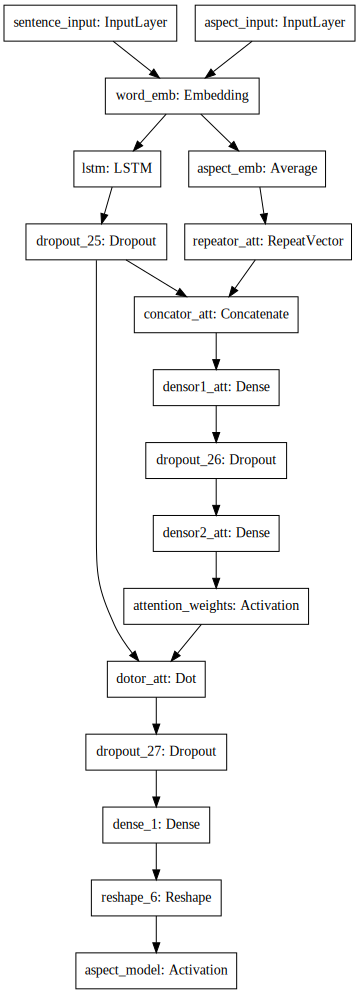

In [47]:
IPython.display.SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
batch_size = 32
train_steps_epoch = len(train_x)/batch_size
# print(train_y.shape)
# print(dev_y.shape)

batch_train_iter = Dataiterator([train_x, train_y, train_aspect], batch_size)
val_steps_epoch = len(dev_x)/batch_size
batch_val_iter = Dataiterator([dev_x, dev_y, dev_aspect], batch_size)

from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_generator(model, batch_train_iter, batch_val_iter):
    
    earlystop_callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                     ModelCheckpoint(filepath=os.path.join('./','{epoch:02d}-{loss:.2f}.check'), \
                                     monitor='val_loss', save_best_only=False, \
                                     save_weights_only=True)
                     ]
    
    def train_gen():
        while True:
            train_batches = [[[X, aspect], [y]] for X, y, aspect in batch_train_iter]
            for train_batch in train_batches:
                yield train_batch
                
                
    def val_gen():
        while True:
            val_batches = [[[X, aspect], [y]] for X, y, aspect in batch_val_iter]
            for val_batch in val_batches:
                yield val_batch
                
    history = model.fit_generator(train_gen(), validation_data=val_gen(), \
                                  validation_steps=val_steps_epoch, steps_per_epoch=train_steps_epoch, \
                                  epochs = 20, callbacks = earlystop_callbacks)
      

Train model

In [49]:
train_generator(model, batch_train_iter, batch_val_iter)

Epoch 1/20
58/57 [==============================] - 19s 334ms/step - loss: 1.0890 - categorical_accuracy: 0.4359 - val_loss: 1.0709 - val_categorical_accuracy: 0.4271
Epoch 2/20
58/57 [==============================] - 17s 285ms/step - loss: 0.9907 - categorical_accuracy: 0.5377 - val_loss: 0.8941 - val_categorical_accuracy: 0.6125
Epoch 3/20
58/57 [==============================] - 17s 285ms/step - loss: 0.8033 - categorical_accuracy: 0.6708 - val_loss: 0.8253 - val_categorical_accuracy: 0.6813
Epoch 4/20
58/57 [==============================] - 16s 283ms/step - loss: 0.7036 - categorical_accuracy: 0.7247 - val_loss: 0.8472 - val_categorical_accuracy: 0.6583
Epoch 5/20
58/57 [==============================] - 17s 287ms/step - loss: 0.6220 - categorical_accuracy: 0.7662 - val_loss: 0.8189 - val_categorical_accuracy: 0.6292
Epoch 6/20
58/57 [==============================] - 17s 285ms/step - loss: 0.5364 - categorical_accuracy: 0.8087 - val_loss: 0.9009 - val_categorical_accuracy: 0.591

### Evaluate

In [ ]:
testPhrases = ["it s fast light and simple to use","other than not being a fan of click pads industry standard these days and the lousy internal speakers it is hard for me to find things about this notebook i do not like especially considering the price tag","tech support would not fix the problem unless i bought your plan for more money"]
testPhrases_array = []
for phrase in testPhrases:
  testPhrase_array = []
  for word in phrase.split(' '):
    idxWord = vocab[word]
    testPhrase_array.append(idxWord)
  testPhrases_array.append(testPhrase_array)

aspects_levels = ['use','pads','support']
aspects_levels_array = []
for asp in aspects_levels:
  aspects_levels_array1 = []
  idxWord = vocab[asp]
  aspects_levels_array1.append(idxWord)
  aspects_levels_array.append(aspects_levels_array1)

  
  
train_x_1 = sequence.pad_sequences(testPhrases_array, maxlen=overal_maxlen)
train_aspect_1 = sequence.pad_sequences(aspects_levels_array, maxlen=overal_maxlen_aspect)


In [ ]:
predictions = []
for i in range(len(testPhrases_array)):
  prediction = model.predict([np.expand_dims(train_x_1[i],0),np.expand_dims(train_aspect_1[i],0)])  
  predictions.append(np.argmax(prediction.flatten()))

In [94]:
predictions = pd.DataFrame(predictions)
testPhrases = pd.DataFrame(testPhrases)
print(aspects_levels)
aspects_levels_2 = pd.DataFrame(aspects_levels)
testPhrases['Aspects'] = (aspects_levels_2)
testPhrases['Predicted Label'] = (predictions)
testPhrases.columns = ['Test review','Aspect','Predicted Label']

['use', 'pads', 'support']


In [95]:
print("Sentence evaluation:")
print("0: Positive. 1: Negative. 2: Neutral")
pd.set_option('display.max_colwidth', -1)
display(testPhrases)

Sentence evaluation:
0: Positive. 1: Negative. 2: Neutral


,Test review,Aspect,Predicted Label
0,it s fast light and simple to use,use,0
1,other than not being a fan of click pads industry standard these days and the lousy internal speakers it is hard for me to find things about this notebook i do not like especially considering the price tag,pads,2
2,tech support would not fix the problem unless i bought your plan for more money,support,1


During training phase is possible to see that only 15 out of 20 epochs were performed by the model. This is due to the early stopping function. We also obtain a high difference between the train accuracy and the validation accuracy due to overfitting. After training several models and configurations (e.g. Learning rate, optimizers and layers) the best validation accuracy obtained was 68%.